In [1]:
import os
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm

GLOVE_DIR = 'drive/MyDrive/Milestone2/glove.6B.100d.txt'
glove_dict = {}
with open(GLOVE_DIR) as f:
    for line in f:
        word, *vector = line.split()
        glove_dict[word]=np.array(vector).astype(float)

re_tokenized = pickle.load(open('drive/MyDrive/Milestone2/re_tokenized_lemma.pkl','rb'))

In [4]:
def get_average_glove_vec(list_of_tokens):
    avg_vec=[]
    for token in list_of_tokens:
    if token in glove_dict:
        avg_vec.append(glove_dict[token])

    if len(avg_vec)>0:
    avg_vec = np.mean(avg_vec, axis=0)
    else:
    avg_vec = np.zeros(100)

    return avg_vec

In [7]:
import pandas as pd
from tqdm import tqdm
import glob

# Load precalculated features
path='drive/MyDrive/Milestone2/'
feature_files = glob.glob(path+"WikiLarge_Train_*2.csv")
features = []
for f in feature_files:
    temp = pd.read_csv(f, index_col=0)
    features.append(temp)
feature_df = pd.concat(features, axis=1)
feature_df = feature_df.fillna(feature_df.mean())

# Load original data
df = pd.read_csv(path+'WikiLarge_Train.csv')
feature_df = pd.concat([df, feature_df], axis=1)
# set the chosen numerical features
chosen_features = ['aoa', 'concrete_score','verb2', 'conc_unknown', 'aoa_perc_known_lem',
        'conc_total', 'syllable_per_word', 'conc_mean_score','dale_chall_score', 'conc_subtlex_score']
chosen_cols = ['original_text', 'label']+chosen_features
df_original = feature_df[chosen_cols]

# calculate average GloVe vectors for each sentence
df_vecs = []
for ls in tqdm(re_tokenized):
    avg_vec = get_average_glove_vec(ls)
    df_vecs.append(avg_vec)

df_original['glove_avg'] = df_vecs

100%|██████████| 416768/416768 [00:11<00:00, 35169.03it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# concatenate the numerical features and calculated GloVe vectors
X1 = df_original[chosen_features].to_numpy()
X2 = np.vstack(df_vecs)
X = np.hstack([X1,X2])

In [9]:
df = df_original.sample(100000, random_state=42)
X_sampled = X[df.index]
y = df['label']

In [11]:
from sklearn.model_selection import train_test_split

Train_X, Test_X, Train_Y, Test_Y = train_test_split(X_sampled, y, test_size=0.2, random_state=42)

In [15]:
Train_X.shape

(80000, 110)

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(bootstrap=True,
 max_depth=50,
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=500)

rf.fit(Train_X, Train_Y)
rf_preds = rf.predict(Test_X)
rf_acc = accuracy_score(Test_Y, rf_preds)
rf_f1 = f1_score(Test_Y, rf_preds)
rf_acc, rf_f1

(0.709, 0.7142857142857143)

In [19]:
pickle.dump(rf, open('drive/MyDrive/Milestone2/trained_models/rf_glove_and_simples_10w.pkl', 'wb'))

In [20]:
reloaded_rf = pickle.load(open('drive/MyDrive/Milestone2/trained_models/rf_glove_and_simples_10w.pkl', 'rb'))
y_score = reloaded_rf.predict_proba(Test_X)

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

rf_fpr, rf_tpr, thresholds = roc_curve(Test_Y, y_score[:,1], pos_label=1)
area = auc(rf_fpr, rf_tpr)

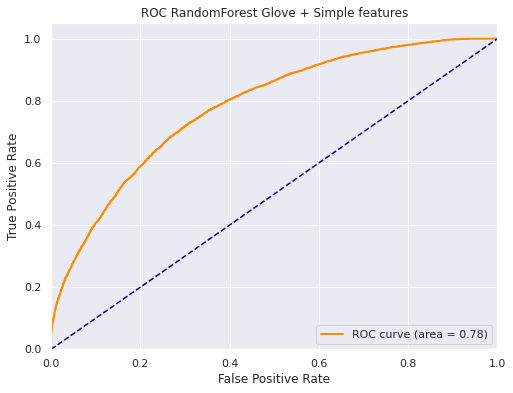

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(8,6))
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForest Glove + Simple features')
plt.legend(loc="lower right")
plt.savefig('ROC_RandomForest_glove_simplefeats.jpg')

In [28]:
roc_df = pd.DataFrame([rf_fpr, rf_tpr]).T
roc_df.columns = ['rf_fpr', 'rf_tpr']
roc_df['feat'] = 'glove_simple'

In [30]:
roc_df.to_csv('roc_glove_simple_100k.csv')

# Skipping SVM with large samples

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(150), random_state=1, max_iter=300).fit(Train_X, Train_Y)
mlp_predict = mlp.predict(Test_X)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

mlp_acc = accuracy_score(Test_Y, mlp_predict)
mlp_f1 = f1_score(Test_Y, mlp_predict)
mlp_acc, mlp_f1

(0.63825, 0.6925332540053546)

In [ ]:
mlp.score(Train_X, Train_Y)

0.64655

In [ ]:
pickle.dump(mlp, open('drive/MyDrive/Milestone2/trained_models/mlp_word2vec_and_simples.pkl', 'wb'))

In [ ]:
reloaded_mlp = pickle.load(open('drive/MyDrive/Milestone2/trained_models/mlp_word2vec_and_simples.pkl', 'rb'))

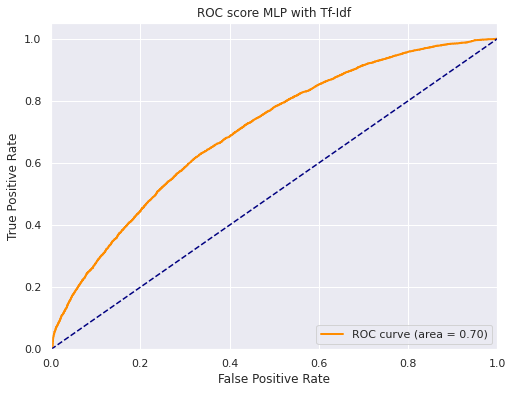

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_score = reloaded_mlp.predict_proba(Test_X)
mlp_fpr, mlp_tpr, thresholds = roc_curve(Test_Y, y_score[:,1], pos_label=1)
area = auc(mlp_fpr, mlp_tpr)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(8,6))
lw = 2
plt.plot(mlp_fpr, mlp_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score MLP with Tf-Idf')
plt.legend(loc="lower right")
plt.savefig('ROC_MLP_glove_simplefeats.jpg')

# Summary

In [ ]:
score_df = pd.DataFrame([[mlp_acc, rf_acc],[mlp_f1, rf_f1]]).T
score_df.columns=['accuracy', 'f1 score']
score_df['model'] = ['MLP','RandomForest']
score_df.to_csv('scores_10w_glove_simplefeats.csv')
score_df

,accuracy,f1 score,model
0,0.63825,0.692533,MLP
1,0.70925,0.715467,RandomForest
